In [1]:
from transformers import logging
from transformers import BertModel, BertTokenizer
from transformers import pipeline
import torch
import torch.nn as nn
from torch.nn.functional import normalize, log_softmax

In [2]:
logging.set_verbosity_error()
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
from TRExData.HardTRExData import HardKnownTRExData
from SentenceComparison.SentenceComparison import SentenceComparison 
from ModelHelpers.fill_mask_helpers import get_probability_from_pipeline_for_token
from ModelHelpers.data_helpers import create_known_filter_getter, create_hard_filter_getter
from relation_templates.templates import get_templates, get_relation_meta, relations, relation_names, get_relation_cardinality
from PipelineCacheWrapper.PipelineCacheWrapper import PipelineCacheWrapper

In [4]:
%%time
unmasker = PipelineCacheWrapper('fill-mask', model='bert-base-cased', top_k=10)

CPU times: user 1.73 s, sys: 300 ms, total: 2.03 s
Wall time: 7.15 s


In [5]:
def model_to_tokens(sentence):
    result = unmasker(sentence)
    result = sorted(result, key=lambda entry: entry["score"], reverse=True)
    return [entry["token_str"] for entry in result]

In [6]:
get_hard_filter = create_hard_filter_getter(model_to_tokens, get_templates)
get_known_filter = create_known_filter_getter(model_to_tokens, get_templates, get_relation_cardinality)

In [7]:
MASK = "[MASK]"
OBJ_LABEL = "obj-label"
SUBJ_LABEL = "sub-label"
VOCABULARY_SIZE = 28996
words = [] 

In [8]:
#relations = ["P140", "P127", "P36", "P159"]
#relations = ["P1303"]
#relations = ["P19", "P413", "P159", "P103"]

In [9]:
TREx = HardKnownTRExData(get_hard_filter, get_known_filter, relations = relations)
TREx.load()
relations = list(TREx.data.keys())

In [10]:
unmasker = PipelineCacheWrapper('fill-mask', model='bert-base-cased', top_k=2000)

In [11]:
@torch.no_grad()
def metric(sentence: str, token: str):
    prob = get_probability_from_pipeline_for_token(unmasker(sentence), token)
    return prob

In [12]:
Comparer = SentenceComparison(relations, get_templates, metric, MASK, get_relation_meta)

In [13]:
Comparer.compare(TREx.data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 738/738 [03:13<00:00,  3.82it/s]


In [14]:
relations

['P159',
 'P37',
 'P1412',
 'P138',
 'P495',
 'P17',
 'P178',
 'P103',
 'P20',
 'P36',
 'P407',
 'P190',
 'P276',
 'P108',
 'P31',
 'P364',
 'P27',
 'P30',
 'P47',
 'P1376',
 'P106',
 'P937',
 'P449',
 'P131',
 'P1303',
 'P127',
 'P279',
 'P740',
 'P19',
 'P527',
 'P264',
 'P1001',
 'P39',
 'P101',
 'P361',
 'P530',
 'P463',
 'P176']

In [15]:
%%time
unmasker.save_to_cache()

CPU times: user 50.7 s, sys: 9.62 s, total: 1min
Wall time: 1min 3s


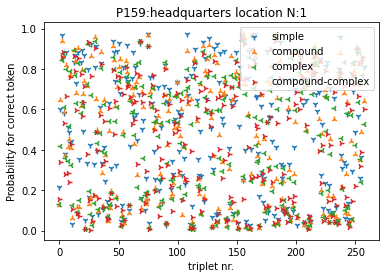

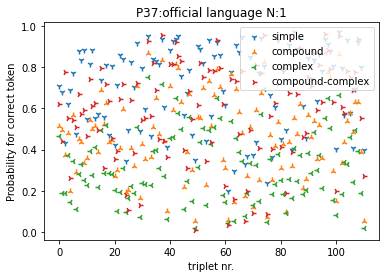

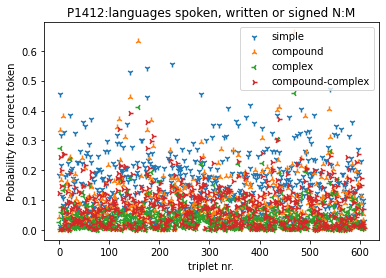

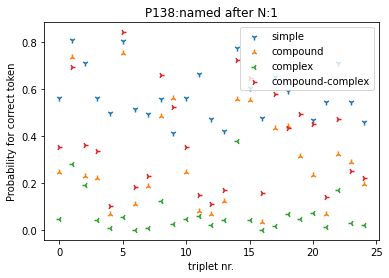

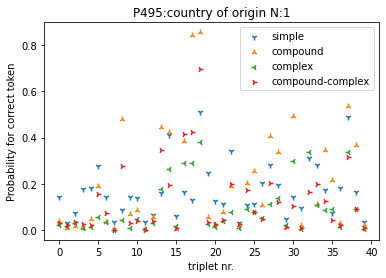

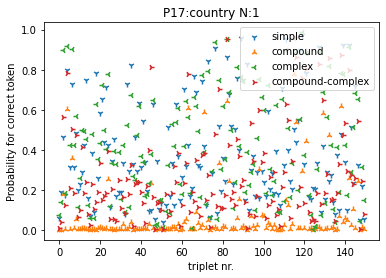

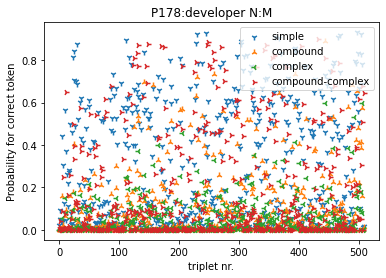

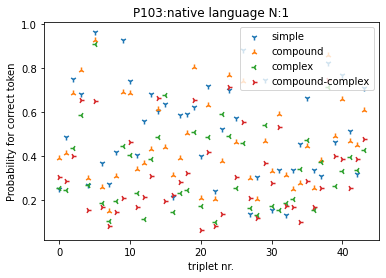

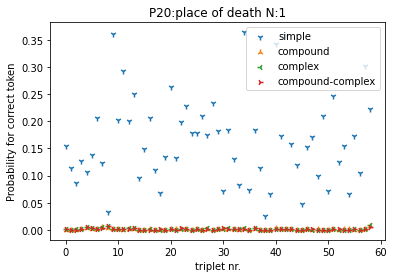

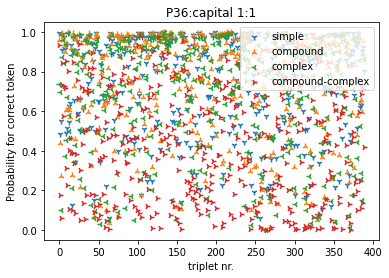

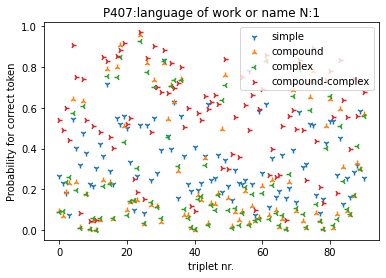

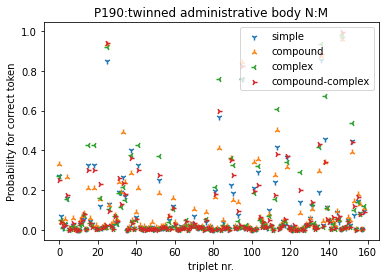

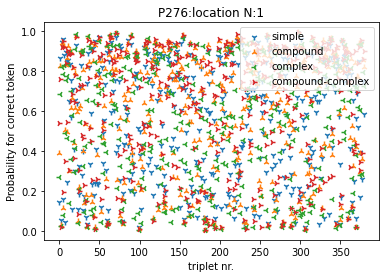

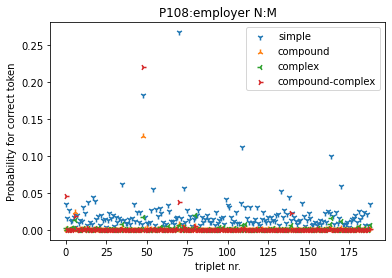

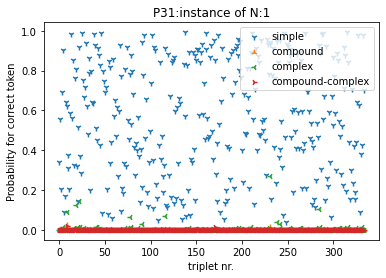

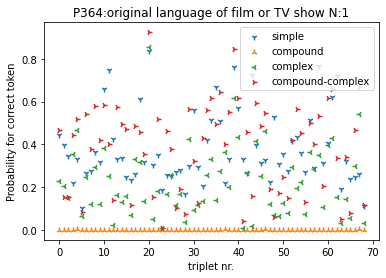

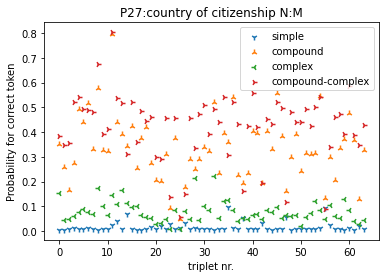

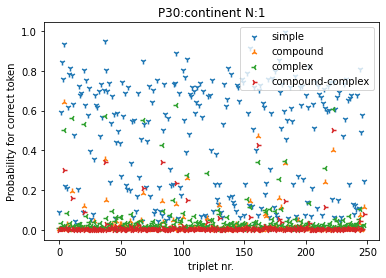

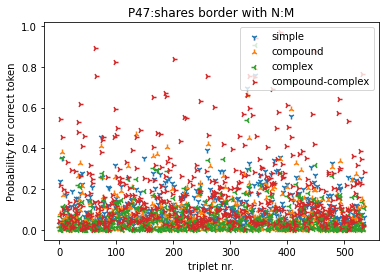

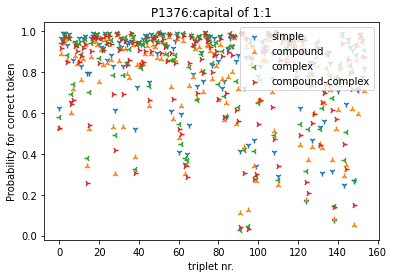

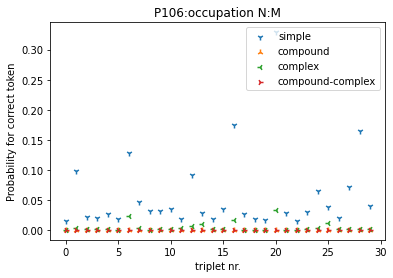

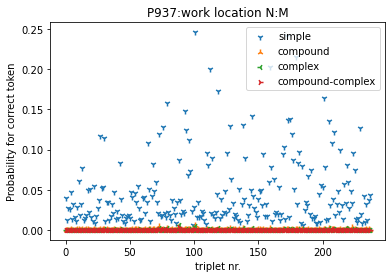

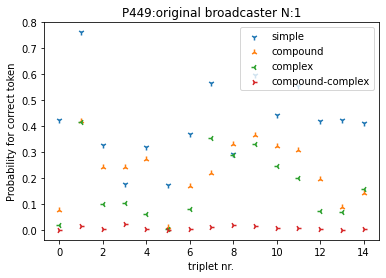

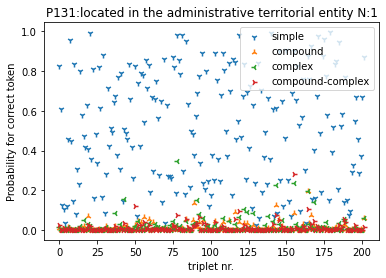

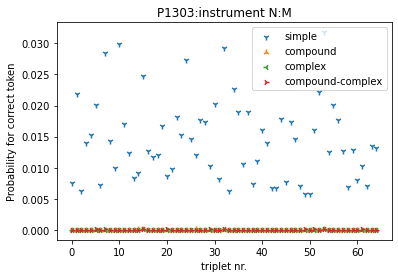

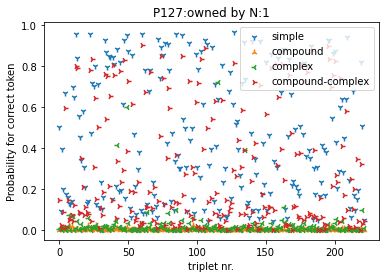

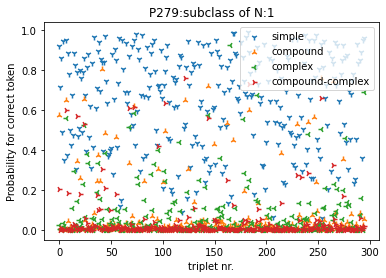

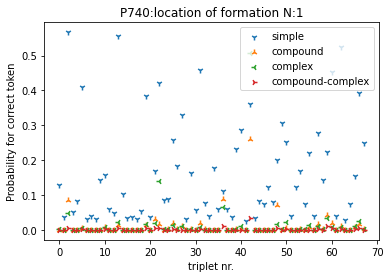

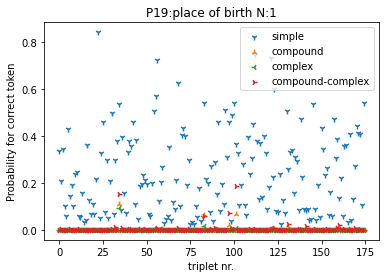

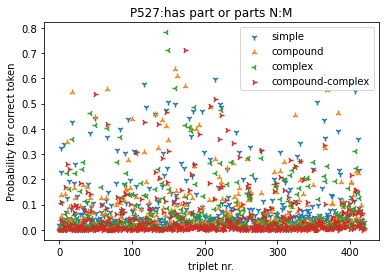

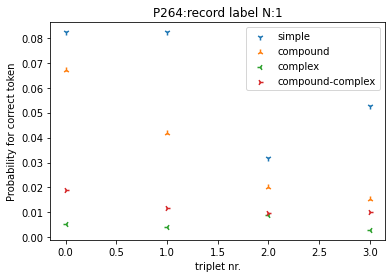

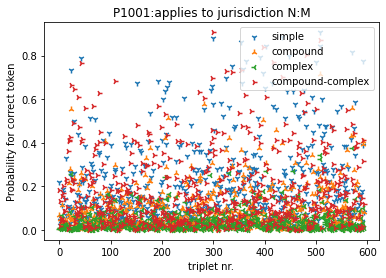

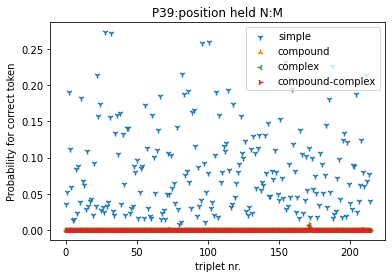

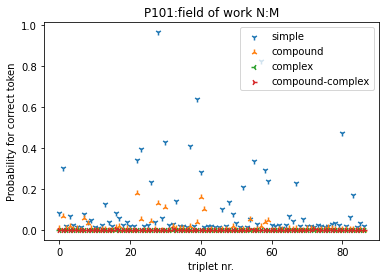

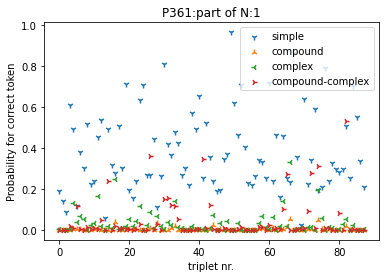

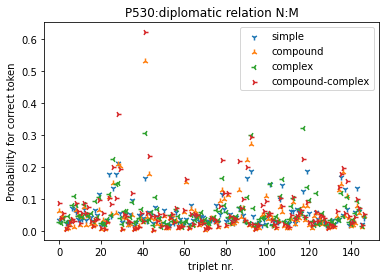

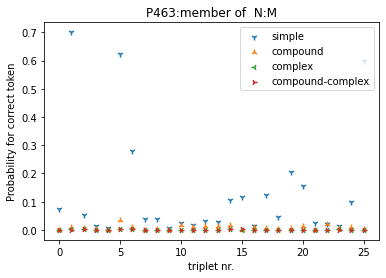

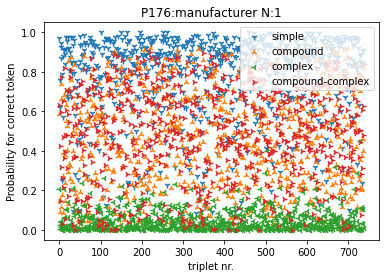

In [16]:
for rel in relations:
    Comparer.plot_comparison_for_relation(rel, "Probability for correct token")

In [17]:
unmasker.save_to_cache()